# Prep Website Data

Prep datafiles for use in specific sections of the website


In [2]:
import numpy as np
import pandas as pd
import pydeck as pdk
import os
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns

import random
import json

In [80]:
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sns.set_style("darkgrid", rc=custom_style)
sns.set_theme(style="whitegrid")


In [29]:
dataDir = '../data'
outputDir = '../websiteData'

In [109]:
arts = []
with open(join(dataDir, 'articleMetadata.json')) as f:
    for i,line in enumerate(f):
        thisArt = json.loads(line)
        if 'isValid' in thisArt.keys():
            arts.append(thisArt)

## Hero

Create a sample of article titles used to drive the hero animation. This sample should be manually spot checked afterward to prune out titles that are less obviously related to the current pandemic. 

In [25]:
# get a random sample of journal articles
random.seed(101101)
sampleArts = random.sample(arts, 1000)

# extract the relevant metadata (title, journal name, etc) for each
# and save to csv
heroData = []
for a in sampleArts:
    title = a['title']
    if title:
        title = title.replace('\n', '').strip()
        
    journal = a['journalTitle']
    if journal:
        journal = journal.replace('\n', '').strip()
    
    heroData.append({
        'title': title,
        'journal': journal,
        'pubDate': a['pubDate']
    })

heroData_df = pd.DataFrame(heroData)
heroData_df.to_csv(join(outputDir, 'heroData.csv'), index=False)

In [22]:
heroData_df.shape

(1000, 3)

## Section I

### Papers per year

For the visualization showing the number of coronavirus related papers from the late 60's on to 2020. 

No processing steps required here, just a note about how that data was acquired: 

The `papersPerYear.csv` was obtained by going to pubmed central and using the covid-19 search string, without the publication date range:

```
"COVID-19"[All Fields] OR "COVID-19"[MeSH Terms] OR "COVID-19 Vaccines"[All Fields] OR "COVID-19 Vaccines"[MeSH Terms] OR "COVID-19 serotherapy"[All Fields] OR "COVID-19 Nucleic Acid Testing"[All Fields] OR "covid-19 nucleic acid testing"[MeSH Terms] OR "COVID-19 Serological Testing"[All Fields] OR "covid-19 serological testing"[MeSH Terms] OR "COVID-19 Testing"[All Fields] OR "covid-19 testing"[MeSH Terms] OR "SARS-CoV-2"[All Fields] OR "sars-cov-2"[MeSH Terms] OR "Severe Acute Respiratory Syndrome Coronavirus 2"[All Fields] OR "NCOV"[All Fields] OR "2019 NCOV"[All Fields] OR (("coronavirus"[MeSH Terms] OR "coronavirus"[All Fields] OR "COV"[All Fields]) ) 
```

Next, using the returned results, I applied a custom filter (using the left hand panel) to define a date range for each year from 1965 onwards. For instance, 1965 was setting the custom date range to `1965/01/01` to `1965/12/31`. 

I manually recorded the number of articles returned by this filter. Repeated for every year thereafter. 



## Section II

### Collaboration map

In order to store this data as efficiently as possible, create separate datasets for:

* a main geoIDs dataset. One row per unique geoID, stores all of the relevant info (addr, state, country, lat, lng) for each geoID. This dataset should be easily indexable

* the collaborations. For each collaboration, we need to know (at minimum) the date, src geoID idx, dst geoID idx


In [16]:
### Create the main geoIDs dataset
cityGeocodes_df = pd.read_csv(join(dataDir, 'cityGeocodes.csv'))

# add idx column
cityGeocodes_df['idx'] = cityGeocodes_df.index

# save a version for site, removing all unecessary columns
siteGeoIDs = cityGeocodes_df[['idx', 'lat', 'lng']]

# write to web folder
siteGeoIDs.to_csv(join(outputDir, 'geoIDs.csv'), float_format='%.2f', index=False)

In [21]:
def getGeoIdx(geoID):
    """ return the index of the specified geoID from the cityGeoCodes_df dataframe """
    indices = cityGeocodes_df.index[cityGeocodes_df['geoID'] == geoID].tolist()
    return indices[0]  # should only ever be 1 value

This step takes ~10min to run

In [42]:
def getGeoIdx(geoID):
    """ return the index of the specified geoID from the cityGeoCodes_df dataframe """
    indices = cityGeocodes_df.index[cityGeocodes_df['geoID'] == geoID].tolist()
    return indices[0]  # should only ever be 1 value


### create the collaborations dataset
collabs_df = pd.read_csv(join(dataDir, 'processed/collaborations.csv'))

# add the srcIdx and dstIdx cols to each row
collabs_df['srcIdx'] = collabs_df['geoID_A'].apply(getGeoIdx)
collabs_df['dstIdx'] = collabs_df['geoID_B'].apply(getGeoIdx)

# drop missing rows
collabs_df.dropna(inplace=True)

# drop the year from pub date to save space
collabs_df['pubDate'] = collabs_df['pubDate'].apply(lambda x: '-'.join(x.split('-')[1:]))

# save a version for site, removing unecessary columns
siteCollabs = collabs_df[['pubDate', 'srcIdx', 'dstIdx']].sort_values('pubDate')


In [44]:
# write data to file
siteCollabs.to_csv(join(outputDir, 'collabsByDate.csv'), index=False)

### Article stats by day
Create a table that show certain publishing stats by day. These values will update as user scrolls through the year

#### -number of articles by day

In [197]:
# calculate the number of collaborations (author to author) for every article
nArts = []
for art in arts:
    nArts.append({
        'PMCID': art['PMCID'],
        'pubDate': art['pubDate'],
    })
    
# store as dataframe
nArts_df = pd.DataFrame(nArts)

# groupby day
nArtsByDay = nArts_df.groupby('pubDate').size().reset_index(name="nArts").sort_values('pubDate')
nArtsByDay['pubDate'] = nArtsByDay['pubDate'].apply(lambda x: '-'.join(x.split('-')[1:]))

In [200]:
nArtsByDay.head()

,pubDate,nArts
0,01-01,26
1,01-02,8
2,01-03,11
3,01-04,4
4,01-05,2


#### -number of geo collaborations by day
Geo collaborations defined as two unique geolocations working together on the same article. Less granular than total collaborations, which are two unique individuals working together on the same article. 

In [147]:
nCollabsByDay = collabs_df.groupby('pubDate').size().reset_index(name='nCollabs')

In [148]:
nGeoCollabsByDay.head()

,pubDate,nGeoCollabs
0,01-01,8
1,01-02,26
2,01-03,39
3,01-04,1
4,01-06,33


### -number of collaborations (author to author) by day

In [181]:
# calculate the number of collaborations (author to author) for every article
nCollabs = []
for art in arts:
    nAuths = art['nAuthors']
    nCollabs.append({
        'PMCID': art['PMCID'],
        'pubDate': art['pubDate'],
        'nCollabs': nAuths * (nAuths-1) / 2
    })
    
# store as dataframe
nCollabs_df = pd.DataFrame(nCollabs)

# groupby day
nCollabsByDay = nCollabs_df[['pubDate', 'nCollabs']].groupby('pubDate').sum().sort_values('pubDate').reset_index()
nCollabsByDay['pubDate'] = nCollabsByDay['pubDate'].apply(lambda x: '-'.join(x.split('-')[1:]))

In [210]:
nCollabsByDay.head()

,pubDate,nCollabs
0,01-01,990.0
1,01-02,160.0
2,01-03,810.0
3,01-04,66.0
4,01-05,55.0


### -merge tables

In [229]:
# use nArtsByDay as base, since it has rows for most day throughout the year
statsByDay = nArtsByDay.merge(nGeoCollabsByDay, how='left').merge(nCollabsByDay, how='left')

# fill any rows (dates) with missing values with 0
for col in ['nCollabs', 'nGeoCollabs', 'nArts']:
    statsByDay[col] = statsByDay[col].fillna(0)
    
# 01-26 is missing. Add this row manually
statsByDay = statsByDay.append({
    'pubDate': '01-26',
    'nArts': 0,
    'nGeoCollabs': 0,
    'nCollabs': 0
}, ignore_index=True)
statsByDay.sort_values('pubDate', inplace=True)

In [231]:
# generate cumulative sum columns for all cols
for col in ['nCollabs', 'nGeoCollabs', 'nArts']:
    statsByDay[f"cum_{col}"] = statsByDay[col].cumsum()

In [232]:
statsByDay

,pubDate,nArts,nGeoCollabs,nCollabs,cum_nCollabs,cum_nGeoCollabs,cum_nArts
0,01-01,26,8.0,990.0,990.0,8.0,26
1,01-02,8,26.0,160.0,1150.0,34.0,34
2,01-03,11,39.0,810.0,1960.0,73.0,45
3,01-04,4,1.0,66.0,2026.0,74.0,49
4,01-05,2,0.0,55.0,2081.0,74.0,51
...,...,...,...,...,...,...,...
360,12-27,53,75.0,733.0,2910055.0,363921.0,92288
361,12-28,239,530.0,8081.0,2918136.0,364451.0,92527
362,12-29,233,367.0,6556.0,2924692.0,364818.0,92760
363,12-30,235,1060.0,11132.0,2935824.0,365878.0,92995


In [233]:
# save to disk
statsByDay[['pubDate', 'cum_nArts', 'cum_nCollabs', 'cum_nGeoCollabs']].to_csv(join(outputDir, 'statsByDay.csv'), index=False)

#### summarize

In [105]:
# summary stats for number of articles per day
print(f"mean: {nArticlesByDay['nArts'].mean()}, max: {nArticlesByDay['nArts'].max()}")

mean: 94.50276243093923, max: 227


In [135]:
# figure out the maximum number of collaborations on one day
dailyMaxIdx = nGeoCollabsByDay['nCollabs'].idxmax()
nGeoCollabsByDay.iloc[dailyMaxIdx]

pubDate     12-16
nCollabs    38697
Name: 346, dtype: object

<AxesSubplot:xlabel='pubDate', ylabel='nCollabs'>

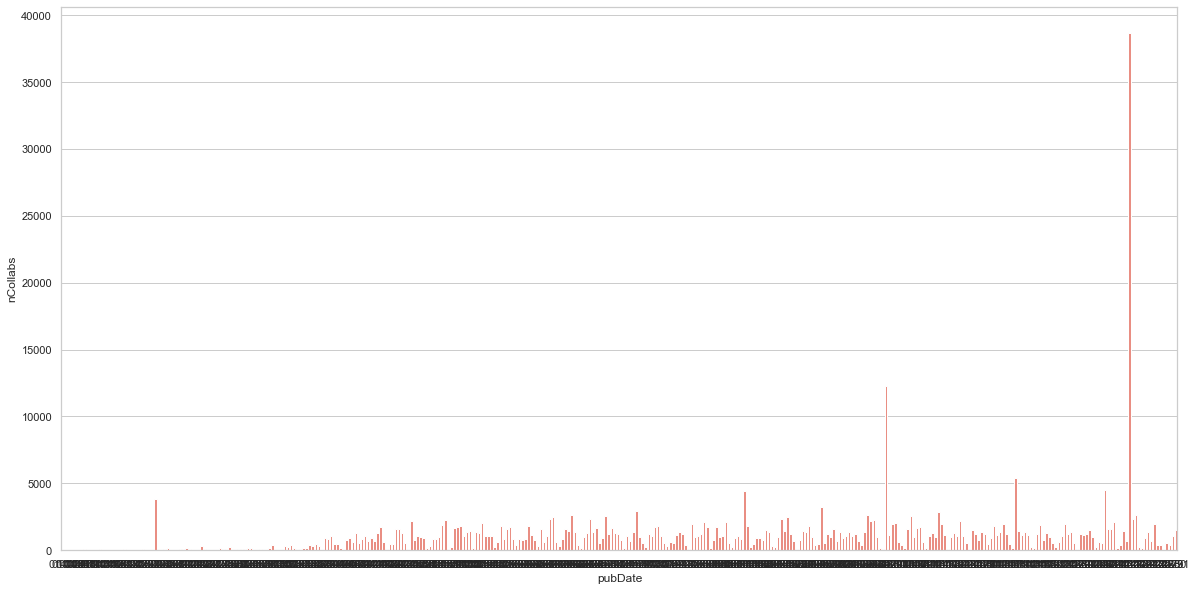

In [83]:
plt.figure(figsize=(20, 10))
sns.barplot(x="pubDate", y="nCollabs", data=collabsByDay, color="salmon")

In December, there's a day where the number of new geo collaborations greatly peaks. Find out why


In [107]:
nArticlesByDay[nArticlesByDay['pubDate'] == '12-16']

,pubDate,nArts
346,12-16,200


There are a lot of articles, but not the most across the full year. So must be a lot of unique geo locations per article. Confirm this

In [145]:
# get the IDs of these articles
Dec16_collabs = collabs_df[collabs_df['pubDate'] == '12-16']
Dec16_PMCIDs = Dec16_collabs['PMCID'].unique().tolist()

# for each id, get the article metadata and report the number of unique geoLocations
Dec16_arts = [x for x in arts if x['PMCID'] in Dec16_PMCIDs]
for art in Dec16_arts:
    uniqueGeoIDs = []
    for aff in art['authors']['affiliations']:
        if aff['hasGeo']:
            if aff['geoID'] not in uniqueGeoIDs:
                uniqueGeoIDs.append(aff['geoID'])
    if len(uniqueGeoIDs) > 10:
        print(f"{art['PMCID']} - nUnique Geos: {len(uniqueGeoIDs)}")


PMC7744014 - nUnique Geos: 16
PMC7739806 - nUnique Geos: 275
PMC7754786 - nUnique Geos: 13
PMC7772353 - nUnique Geos: 13
PMC7745688 - nUnique Geos: 14


Yup, article PMC7739806 has 275 unique GEOs associated with it. That computes to 37,675 pairs of collaborations ( n * (n-1) / 2 )

In [146]:
art7739806 = [x for x in arts if x['PMCID'] == 'PMC7739806'][0]